In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

### 1. Loading the dataset and handling missing values

In [ ]:
np.random.seed(42) #For reproducibility

In [ ]:
data = pd.read_csv('UCI_Credit_Card.csv')
print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

Dataset shape: (30000, 25)
Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']


In [ ]:
# Basic information about the dataset
print("DATASET OVERVIEW")
print()
print(data.info())

DATASET OVERVIEW

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2    

In [ ]:
print("\nFirst 5 rows:")
data.head()


First 5 rows:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
print("\nDataset statistics:")
data.describe()


Dataset statistics:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [ ]:
# Checking target variable distribution
target_col = 'default.payment.next.month'
print(f"\nTarget variable distribution:")
print(data[target_col].value_counts())
print(f"Default rate: {data[target_col].mean():.2%}")


Target variable distribution:
default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64
Default rate: 22.12%


In [ ]:
def analyze_missing_values(df):
    """
    Analyze missing values in the dataset
    """
    missing_counts = df.isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing_Count': missing_counts,
        'Missing_Percentage': missing_percentages
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) > 0:
        print("Missing values found:")
        print(missing_df)
        
        # Visualize missing values
        plt.figure(figsize=(10, 6))
        plt.bar(missing_df.index, missing_df['Missing_Percentage'])
        plt.title('Missing Values by Column')
        plt.xlabel('Columns')
        plt.ylabel('Missing Percentage (%)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values found in the dataset!")
    
    return missing_df

In [ ]:
missing_analysis = analyze_missing_values(data)

No missing values found in the dataset!


### 2. EDA, Correlation Analysis and Feature Selection

In [ ]:
def perform_eda(X, y):
    """
    Perform exploratory data analysis
    """
    # Target distribution
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    y.value_counts().plot(kind='bar')
    plt.title('Target Variable Distribution')
    plt.xlabel('Default (0=No, 1=Yes)')
    plt.ylabel('Count')
    
    # Feature distributions
    numeric_features = X.select_dtypes(include=[np.number]).columns[:5]
    
    for i, feature in enumerate(numeric_features):
        plt.subplot(2, 3, i+2)
        plt.hist(X[feature], bins=30, alpha=0.7)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation with target
    combined_data = pd.concat([X, y], axis=1)
    target_corr = combined_data.corr()[target_col].abs().sort_values(ascending=False)
    
    print("Top 10 features correlated with target:")
    print(target_corr.head(11)[1:])  # Exclude self-correlation
    
    return target_corr

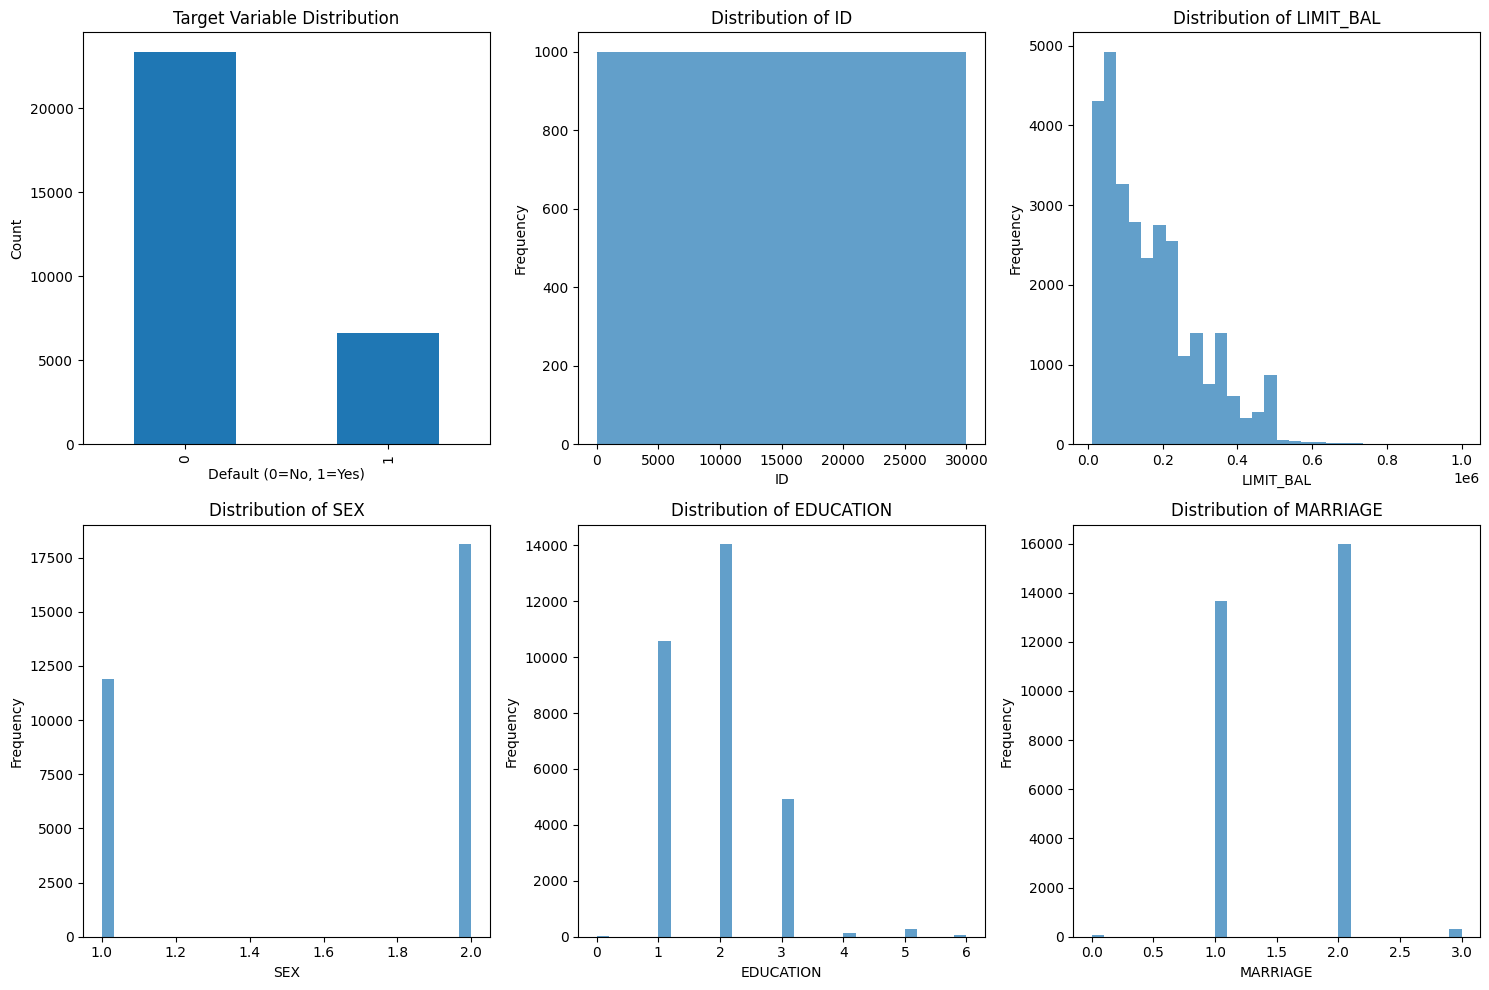

Top 10 features correlated with target:
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
LIMIT_BAL    0.153520
PAY_AMT1     0.072929
PAY_AMT2     0.058579
PAY_AMT4     0.056827
Name: default.payment.next.month, dtype: float64


In [ ]:
X = data.drop(columns=[target_col])
y = data[target_col]
target_correlations = perform_eda(X, y)

In [ ]:
def analyze_correlations_and_remove_redundant(X, threshold=0.9):
    """
    Analyze correlations and remove redundant features
    """
    # Calculate correlation matrix
    corr_matrix = X.corr().abs()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated feature pairs
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop (correlation > threshold)
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    if to_drop:
        print(f"Highly correlated features (threshold > {threshold}): {to_drop}")
        X_reduced = X.drop(columns=to_drop)
        print(f"Features reduced from {X.shape[1]} to {X_reduced.shape[1]}")
    else:
        print(f"No highly correlated features found (threshold > {threshold})")
        X_reduced = X.copy()
    
    return X_reduced, to_drop

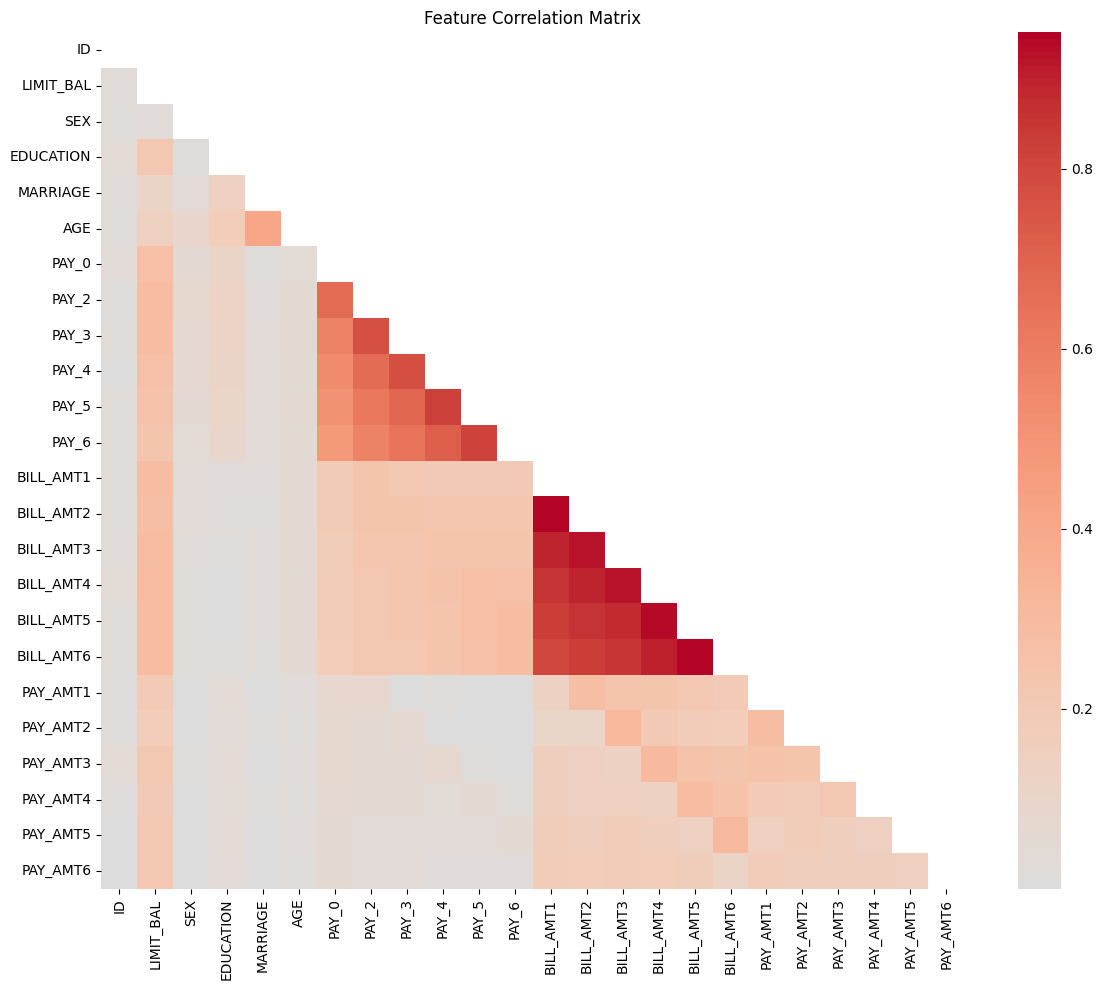

Highly correlated features (threshold > 0.9): ['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
Features reduced from 24 to 19


In [ ]:
X_reduced, dropped_features = analyze_correlations_and_remove_redundant(X, threshold=0.9)

In [ ]:
X_reduced.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

### 3. Train-Test Split and Scaling

In [ ]:
def prepare_data_for_modeling(X, y, test_size=0.2, random_state=42):
    """Split data and apply scaling"""
    print("\n4. DATA PREPARATION FOR MODELING")
    print("-" * 40)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state, stratify=y)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Test set shape: {X_test_scaled.shape}")
    print(f"Class distribution in training set:")
    print(pd.Series(y_train).value_counts())
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data_for_modeling(X, y)


4. DATA PREPARATION FOR MODELING
----------------------------------------
Training set shape: (24000, 24)
Test set shape: (6000, 24)
Class distribution in training set:
default.payment.next.month
0    18691
1     5309
Name: count, dtype: int64


### 4. Applying SMOTE to handle Class Imbalance

In [ ]:
def apply_smote(X_train, y_train):
    """Apply SMOTE to handle class imbalance"""
    print("\n5. HANDLING CLASS IMBALANCE WITH SMOTE")
    print("-" * 45)
    
    print("Before SMOTE:")
    print(pd.Series(y_train).value_counts())
    
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    print("\nAfter SMOTE:")
    print(pd.Series(y_train_smote).value_counts())
    
    return X_train_smote, y_train_smote

In [ ]:
X_train_smote, y_train_smote = apply_smote(X_train_scaled, y_train)


5. HANDLING CLASS IMBALANCE WITH SMOTE
---------------------------------------------
Before SMOTE:
default.payment.next.month
0    18691
1     5309
Name: count, dtype: int64

After SMOTE:
default.payment.next.month
0    18691
1    18691
Name: count, dtype: int64


### 5. Dimensionality Reduction

In [ ]:
def apply_pca(X_train, X_test, variance_threshold=0.95):
    """Apply PCA for dimensionality reduction if beneficial"""
    print("PRINCIPAL COMPONENT ANALYSIS")
    print()
    
    pca = PCA()
    pca.fit(X_train)
    
    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    print(f"Original number of features: {X_train.shape[1]}")
    print(f"Components needed for {variance_threshold*100}% variance: {n_components}")
    
    # Visualize explained variance
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold*100}% threshold')
    plt.axvline(x=n_components, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.bar(range(1, min(21, len(pca.explained_variance_ratio_) + 1)), 
            pca.explained_variance_ratio_[:20])
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Individual Component Variance (First 20)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Apply PCA if it reduces dimensions significantly
    if n_components < X_train.shape[1] * 0.8:  # If PCA reduces features by at least 20%
        print(f"\nApplying PCA with {n_components} components...")
        pca_final = PCA(n_components=n_components, random_state=42)
        X_train_pca = pca_final.fit_transform(X_train)
        X_test_pca = pca_final.transform(X_test)
        return X_train_pca, X_test_pca, pca_final
    else:
        print("\nPCA not beneficial - keeping original features")
        return X_train, X_test, None

PRINCIPAL COMPONENT ANALYSIS

Original number of features: 24
Components needed for 95.0% variance: 16


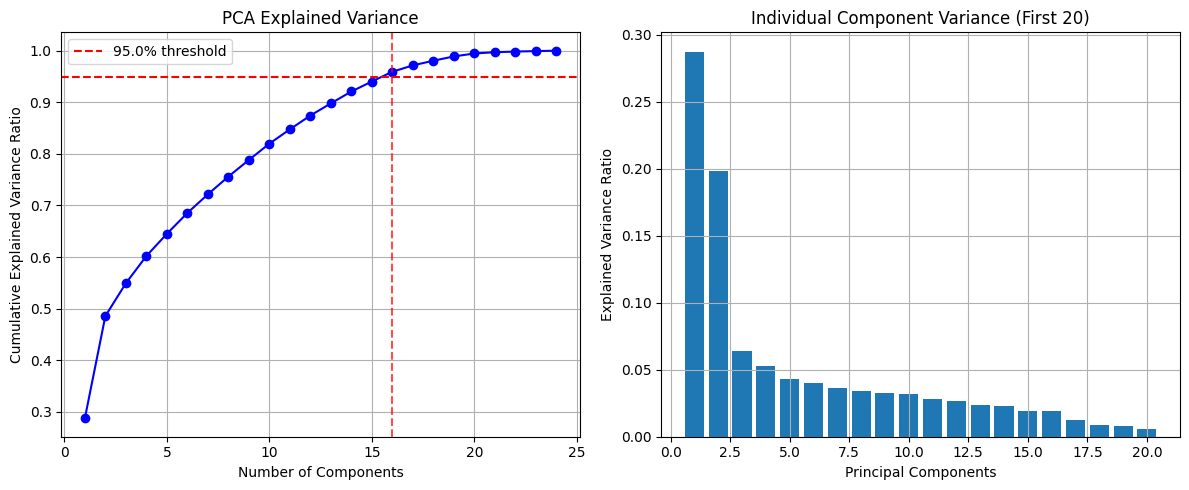


Applying PCA with 16 components...


In [ ]:
X_train_final, X_test_final, pca_model = apply_pca(X_train_smote, X_test_scaled)

### 6. Model Building

In [ ]:
def build_ensemble_models(X_train, y_train, X_test, y_test):
    """Build and train ensemble of Random Forest, XGBoost, and Logistic Regression"""
    print("\n7. ENSEMBLE MODEL BUILDING")
    print("-" * 35)
    
    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(
        n_estimators=250, #100
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
        n_estimators=250, #100
        max_depth=10,
        learning_rate=0.01, #0.1
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
        ),
        'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=2000,
        solver='liblinear'
        )
    }
    
    # Train models and store results
    trained_models = {}
    predictions = {}
    probabilities = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        predictions[name] = y_pred
        probabilities[name] = y_pred_proba
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"{name} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}")
    
    return trained_models, predictions, probabilities

In [ ]:
def ensemble_evaluation(predictions, probabilities, y_test):
    """Create ensemble predictions and comprehensive evaluation"""
    print("\n8. ENSEMBLE EVALUATION")
    print("-" * 30)
    
    # Create ensemble predictions (majority voting for classification, average for probabilities)
    ensemble_pred = np.round(np.mean([predictions['Random Forest'], 
                                    predictions['XGBoost'], 
                                    predictions['Logistic Regression']], axis=0))
    
    ensemble_proba = np.mean([probabilities['Random Forest'], 
                             probabilities['XGBoost'], 
                             probabilities['Logistic Regression']], axis=0)
    
    # Calculate ensemble metrics
    ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
    ensemble_roc_auc = roc_auc_score(y_test, ensemble_proba)
    
    print(f"\nEnsemble Results:")
    print(f"Accuracy: {ensemble_accuracy:.4f}")
    print(f"ROC-AUC: {ensemble_roc_auc:.4f}")
    
    # Detailed evaluation
    print(f"\nClassification Report:")
    print(classification_report(y_test, ensemble_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, ensemble_pred)
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Ensemble Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # ROC Curves
    plt.subplot(1, 3, 2)
    
    # Plot ROC curves for all models
    for name in probabilities.keys():
        fpr, tpr, _ = roc_curve(y_test, probabilities[name])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, probabilities[name]):.3f})')
    
    # Plot ensemble ROC curve
    fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_proba)
    plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (AUC = {ensemble_roc_auc:.3f})', 
             linewidth=3, linestyle='--')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    
    # Model comparison
    plt.subplot(1, 3, 3)
    model_names = list(predictions.keys()) + ['Ensemble']
    accuracies = [accuracy_score(y_test, predictions[name]) for name in predictions.keys()] + [ensemble_accuracy]
    roc_aucs = [roc_auc_score(y_test, probabilities[name]) for name in probabilities.keys()] + [ensemble_roc_auc]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
    plt.bar(x + width/2, roc_aucs, width, label='ROC-AUC', alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return ensemble_pred, ensemble_proba

In [ ]:
trained_models, predictions, probabilities = build_ensemble_models(X_train_final, y_train_smote, X_test_final, y_test)


7. ENSEMBLE MODEL BUILDING
-----------------------------------

Training Random Forest...
Random Forest - Accuracy: 0.7843, ROC-AUC: 0.7570

Training XGBoost...
XGBoost - Accuracy: 0.7663, ROC-AUC: 0.7554

Training Logistic Regression...
Logistic Regression - Accuracy: 0.6698, ROC-AUC: 0.7077



8. ENSEMBLE EVALUATION
------------------------------

Ensemble Results:
Accuracy: 0.7783
ROC-AUC: 0.7498

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4673
           1       0.50      0.54      0.52      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.69      0.69      6000
weighted avg       0.78      0.78      0.78      6000



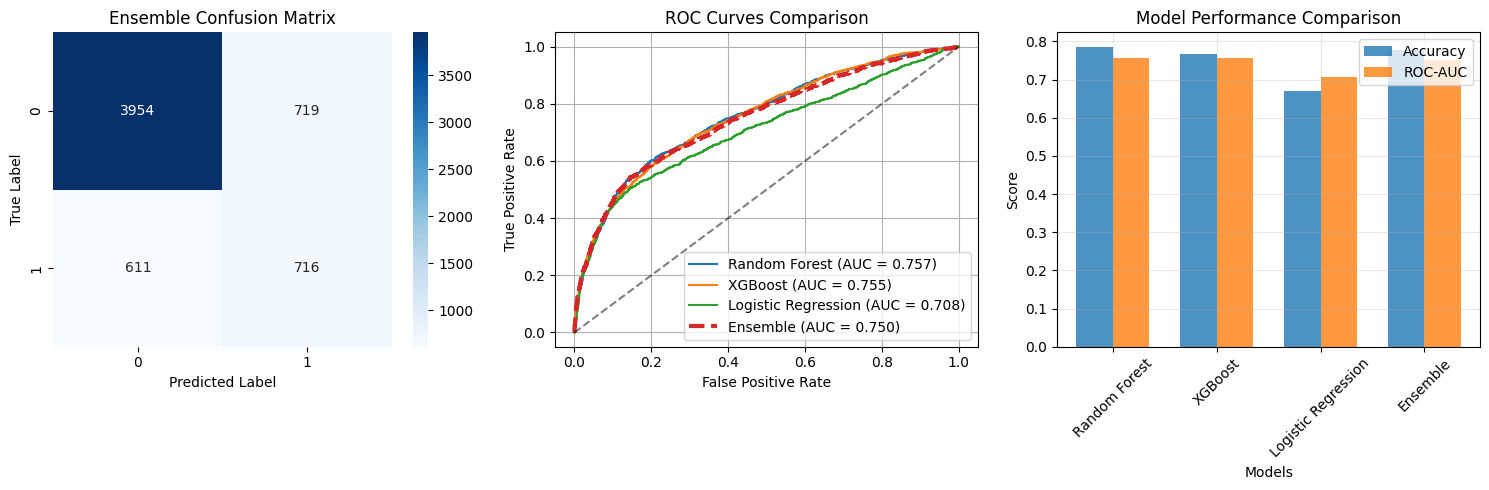

In [ ]:
ensemble_pred, ensemble_proba = ensemble_evaluation(predictions, probabilities, y_test)